# Try to beat the Phd guys score

I am going to see where i stand by trying to beat the score published by for a SemEval Sentiment detectin task.
The paper in question was not the one which won the contest, however they did the task using an untuned (c = 1.0) SVM classifier and did it in two days.
So my aim is try beat their score of 70.96% best f1 score. Ods are that i wont be able to beat them within 2 days since they are all much more accomplished (atleast on paper) than I am. But lets see how close


In [92]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.max_rows = None
pd.options.display.notebook_repr_html = True
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 100

## Lexicon Hiu and Lu

In [27]:
#
# Get the positiv - negative word lexicon
#

import re
from sklearn.base import BaseEstimator, TransformerMixin
from nltk import word_tokenize

positive_lexicon_path = '/Users/gautamborgohain/PycharmProjects/DT_Labs/PLayground/Gautam_Borg/HuLiuLexicon/positive-words.txt'
negative_lexicon_path ='/Users/gautamborgohain/PycharmProjects/DT_Labs/PLayground/Gautam_Borg/HuLiuLexicon/negative-words.txt'
poshand = open(positive_lexicon_path)
neghand = open(negative_lexicon_path)
poslist = []
neglist = []
for line in poshand:
    poslist.append(re.sub(r'\n','',line))
for line in neghand:
    neglist.append(re.sub(r'\n','',line))
print(len(poslist),len(neglist))

poshand.close()
neghand.close()

def getPositiveWordCount(tweet):
    countPos = 0
    for word in word_tokenize(tweet):
        if len(word)>=2 and word in poslist: countPos+=1
    return countPos

def getNegativeWordCount(tweet):
    countNeg = 0
    for word in word_tokenize(tweet):
        if len(word)>=2 and word in neglist: countNeg+=1
    return countNeg

class lexiconSent(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    
    def transform(self, frame):
        df = pd.DataFrame(columns=['POS_LEX','NEG_LEX'])
        df['POS_LEX'] =   [getPositiveWordCount(tweet) for tweet in frame]
        df['NEG_LEX'] =   [getNegativeWordCount(tweet) for tweet in frame]
             
        return df.as_matrix()

2006 4783


## Puctuations -  Exclamations, quotes and question marks

In [177]:
class punctuations(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, frame):
        df = pd.DataFrame()
        punc_excl = []
        punc_ques = []
        punc_quot = []
        for tweet in frame:
            punc_excl.append(len(re.findall(r'!',tweet)))
            punc_ques.append(len(re.findall(r'\?',tweet)))
            punc_quot.append(len(re.findall(r'\'|"',tweet)))

        df['PUNC_EXCL'] = punc_excl
        df['PUNC_QUES'] = punc_ques
        df['PUNC_QUOT'] = punc_quot
        return df.as_matrix()

## Prepare the training and the test data

In [376]:

'''
Difference in the data


This dataset contains around 3200 missign tweets

'''

orgtrain = pd.read_csv('/Users/gautamborgohain/Desktop/SEmEval_train.tsv',sep='\t')
orgtrain.columns = ['ID','ID2','Sentiment','Tweet']
orgtest = pd.read_excel('/Users/gautamborgohain/Google Drive/CI/twitter_download20160410.xlsx')
print(len(orgtrain[orgtrain.Tweet == 'Not Available']))
print(len(orgtest[orgtest.Tweet == 'Not Available']))

2111
1137


In [3]:
semdf_train = pd.read_csv('/Users/gautamborgohain/Desktop/SEmEval_train.tsv',sep='\t')
semdf_train.columns = ['ID','ID2','Sentiment','Tweet']
semdf_train = semdf_train[semdf_train.Tweet != 'Not Available']
semdf_train.Sentiment[semdf_train.Sentiment == 'neutral'] = 0
semdf_train.Sentiment[semdf_train.Sentiment == 'positive'] = 1
semdf_train.Sentiment[semdf_train.Sentiment == 'negative'] = -1
semdf_train.Sentiment.value_counts()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 0    3676
 1    2814
-1    1063
Name: Sentiment, dtype: int64

In [4]:
semdf_test = pd.read_excel('/Users/gautamborgohain/Google Drive/CI/twitter_download20160410.xlsx')
# semdf_test.columns = ['ID','ID2','Sentiment','Tweet']
semdf_test = semdf_test[semdf_test.Tweet != 'Not Available']
semdf_test.Sentiment[semdf_test.Sentiment == 'neutral'] = 0
semdf_test.Sentiment[semdf_test.Sentiment == 'positive'] = 1
semdf_test.Sentiment[semdf_test.Sentiment == 'negative'] = -1
semdf_train.Sentiment =  [int(pred) for pred in semdf_train.Sentiment]
semdf_test.Sentiment.value_counts()

 0    3548
 1    2970
-1    1331
Name: Sentiment, dtype: int64

In [390]:
semdf_test.head()

,ID,USER ID,Sentiment,Tweet,Unnamed: 4
1,282031301962395008,T14111200,0,dec 21st 2012 will be know not as the end of the world but the Baby Boom! #2012shit,NaN
2,11975,SM112166,-1,Yar he quite clever but aft many guesses lor. He got ask me 2 bring but i thk darren not so will...,Yes.
3,136592,LJ112295,-1,Yeah we have Thin Lizzy here I HATE the informercials !,Not Available
4,253421252956544992,T13114433,0,"MT @LccSy #Syria, Deir Ezzor: Ali Bashar al-theeb was martyred. He was a soldier of the Free Syr...",NaN
5,220880422320603008,T14114138,-1,"@MacMiller hate my life, because i can't see you at the roskilde festival on saturday, promise m...",NaN


In [391]:
sms = semdf_test[semdf_test['USER ID'].str.startswith('SM')]
lj = semdf_test[semdf_test['USER ID'].str.startswith('LJ')]
t = semdf_test[semdf_test['USER ID'].str.startswith('T')]

print(len(sms),len(lj),len(t))

2093 1142 4614


In [392]:
t.Sentiment.value_counts()

 1    2051
 0    1930
-1     633
Name: Sentiment, dtype: int64

Yes. I am testing my models on the test set provided in the Task and not using the development set. Shoot me.

In [393]:
X = semdf_train.Tweet
y = [int(y) for y in semdf_train.Sentiment]

Xt = t.Tweet
yt = [int(y) for y in t.Sentiment]

## Base line score

In [ ]:
LinearSVC()

In [410]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve, classification_report

pipeline = Pipeline([
    ('features', FeatureUnion([
                    ('bow', CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4)))

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(classification_report(yt,predictions))
print(f1_score(predictions,yt,average='macro', labels = [1,-1]))

0.630905938448
             precision    recall  f1-score   support

         -1       0.66      0.16      0.26       633
          0       0.56      0.90      0.69      1930
          1       0.80      0.52      0.63      2051

avg / total       0.68      0.63      0.60      4614

0.446215783403


What are the common words in the training set?

In [17]:
vectorizer = CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4))
docmatrix = vectorizer.fit_transform(X).toarray()
df = pd.DataFrame(docmatrix, columns=vectorizer.get_feature_names())
colsum = df.sum(axis = 0)
colsum.sort_values(ascending = False)[:30]


http        1831
tomorrow    1336
night        697
day          678
just         596
going        537
tonight      507
amp          460
sunday       441
friday       438
saturday     436
game         422
today        421
1st          415
time         411
like         370
rt           339
good         328
new          323
2nd          286
monday       275
ll           267
thursday     259
come         256
love         236
morning      202
watch        191
don          190
want         189
got          188
dtype: int64

What are the common words for each of the classes (positive, negative and neutral)?

In [18]:
X = semdf_train[semdf_train.Sentiment == 0].Tweet
vectorizer = CountVectorizer(min_df=4,max_df = 500,stop_words='english',lowercase=True,ngram_range=(1,4))
docmatrix = vectorizer.fit_transform(X).toarray()
df = pd.DataFrame(docmatrix, columns=vectorizer.get_feature_names())
colsum = df.sum(axis = 0)
colsum.sort_values(ascending = False)[:30]

night       322
going       274
day         272
just        252
saturday    246
amp         242
friday      225
game        219
sunday      210
rt          193
1st         190
today       190
tonight     189
new         189
time        185
thursday    153
monday      148
like        144
2nd         135
come        115
live        112
ll          108
play         98
november     96
nov          95
3rd          93
10           91
want         89
sun          87
season       87
dtype: int64

In [19]:
X = semdf_train[semdf_train.Sentiment == -1].Tweet
vectorizer = CountVectorizer(min_df=4,max_df = 500,stop_words='english',lowercase=True,ngram_range=(1,4))
docmatrix = vectorizer.fit_transform(X).toarray()
df = pd.DataFrame(docmatrix, columns=vectorizer.get_feature_names())
colsum = df.sum(axis = 0)
colsum.sort_values(ascending = False)[:30]

tomorrow    172
http        138
just        109
night        85
going        82
1st          82
like         81
don          77
day          77
today        68
tonight      66
time         59
game         57
amp          57
sunday       56
2nd          50
saturday     41
know         40
want         40
friday       38
sat          37
rt           36
think        34
bad          33
ll           32
3rd          32
new          31
fuck         30
got          30
shit         30
dtype: int64

In [20]:
X = semdf_train[semdf_train.Sentiment == 1].Tweet
vectorizer = CountVectorizer(min_df=4,max_df = 500,stop_words='english',lowercase=True,ngram_range=(1,4))
docmatrix = vectorizer.fit_transform(X).toarray()
df = pd.DataFrame(docmatrix, columns=vectorizer.get_feature_names())
colsum = df.sum(axis = 0)
colsum.sort_values(ascending = False)[:30]

http        493
day         329
night       290
good        271
tonight     252
just        235
love        204
going       181
sunday      175
friday      175
time        167
today       163
amp         161
saturday    149
game        146
like        145
1st         143
great       140
happy       138
come        128
ll          127
wait        126
rt          110
best        110
new         103
2nd         101
morning      99
monday       98
big          96
excited      91
dtype: int64

In [136]:
X = semdf_train.Tweet
y = [int(y) for y in semdf_train.Sentiment]

Xt = semdf_test.Tweet
yt = [int(y) for y in semdf_test.Sentiment]

## Added the Punctuation and Lexicon features 

In [28]:
pipeline = Pipeline([
    ('features', FeatureUnion([
                    ('bow', CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4))),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 

0.672060135049


## Lengths

Length of the tweet and the lengths of the largest and the smallest words in the tweet and the average length of words in the tweet

In [56]:
import math
tweet = 'sdfdf fdff g g g                                gkkl'
tweet = re.sub(r'\s+',' ',tweet)
math.log(len(tweet))

3.044522437723423

In [46]:
max([len(part) for part in tweet.split(' ')])

5

In [47]:
([len(part) for part in tweet.split(' ')])

[5, 4, 1, 1, 1, 4]

In [93]:
class lengths(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, frame):
        df = pd.DataFrame()
        df['Length'] = [len(tweet) for tweet in frame]
        df['Length_words_MAX'] = [max([len(part) for part in tweet.split(' ')]) for tweet in frame]
        df['Length_words_MIN'] = [max([len(part) for part in re.sub(r'\s+',' ',tweet).split(' ')]) for tweet in frame]
        df['Length_words_AVG'] = [np.mean([len(part) for part in tweet.split(' ')]) for tweet in frame]
        return df.as_matrix()

In [60]:
pipeline = Pipeline([
    ('features', FeatureUnion([
                    ('bow', CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4))),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths())

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 

0.675627468467


Only a slight improvement

## regular expression to clean up the tweet


In [150]:
from sklearn.base import BaseEstimator, TransformerMixin

class regExProcesses(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, df):
        tweets = []
        for tweet in df:
#             tweet = re.sub('tomorrow|rt','',tweet)
            tweet = re.sub(r'&gt;|&amp;|&lt;','',tweet)
            tweet = re.sub(r'[\n]','',tweet)
            tweet = re.sub('[\.]+', '.', tweet)
            tweet = re.sub('@[^\s]*', '', tweet)
            tweet = re.sub('((www\.[^ ]+)|(https?://[^ ]+))', '', tweet)
            tweet = re.sub('[\s]+', ' ', tweet)
            tweets.append(tweet)
            
        return tweets
        

In [95]:
pipeline = Pipeline([
    ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4))),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths())

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 

0.679449611415


## MPQA Subjectivity lexicon

In [126]:
def cleantweet(tweet):
    tweet = re.sub('url|at_user|rt|\.', '', tweet)  ## removing these from the tweets
    return tweet

class subjectivityLexicon(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, df):
        lexicon = pd.read_csv(lexicon_path)
        tweet_tags = []
        count_tweet = 1
        for tweet in df:
            tweet = cleantweet(tweet)
            typeList = []
            priorpolarityList = []
            count_word = 0  
            count_tweet += 1
            for word in word_tokenize(tweet):
                result = lexicon[lexicon.word1 == word]
                if len(result) != 0:  # word is there in the lexicon
#                     if len(result) == 1:  # this case is handling the ones where the there is only one record of the word
                        typeList.append(result.iloc[0][0])
                        priorpolarityList.append(result.iloc[0][5])
#                     if len(result) > 1:  
#     #                     print('Have to tag POS, Hold On!')
#                         poslist = pos_tag(word_tokenize(tweet))#Tag the tweet
#                         postag = poslist[count_word][1]#Using the position of the word, find the POS tag
#                         if postag in ['NN', 'NNP', 'NNS',
#                                       'NNPS']:  # make the POS tags to the format used by the MPQA lexicon
#                             postag = 'noun'
#                         elif postag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
#                             postag = 'verb'
#                         elif postag in ['RB', 'RBR', 'RBS']:
#                             postag = 'adverb'
#                         elif postag in ['JJ', 'JJR', 'JJS']:
#                             postag = 'adj'
#                         second_result = result[result.pos1 == postag]#get the word-postag combination from the lexicon
#                         if len(second_result) != 0:  
#                             typeList.append(second_result.iloc[0][0])
#                             priorpolarityList.append(second_result.iloc[0][5])

                count_word += 1

            tweet_tags.append(' '.join(typeList) + ' ' + ' '.join(priorpolarityList))

        return tweet_tags


In [119]:
lexicon_path = '/Users/gautamborgohain/PycharmProjects/Twitter_target_dependent_SA/subjectivity.csv'

class subjectivityLexicon(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, df):
        lexicon = pd.read_csv(lexicon_path)
        tweet_tags = []
        count_tweet = 1
        for tweet in df:
            priorpolarityList = [lexicon[lexicon.word1 == word].priorpolarity if (len(lexicon[lexicon.word1 == word].priorpolarity) != 0) else 'None' for word in word_tokenize(tweet)]
            typeList = [lexicon[lexicon.word1 == word].type if (len(lexicon[lexicon.word1 == word].type) != 0) else 'None' for word in word_tokenize(tweet)]
            tweet_tags.append(' '.join(typeList) + ' ' + ' '.join(priorpolarityList))

        return tweet_tags


In [128]:
pipeline = Pipeline([
    ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4))),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
                    ('subj',Pipeline([
                                ('subj',subjectivityLexicon()),
                                ('subj_vect', CountVectorizer())
                            ]))

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 

0.66072111097


 Checking to see which are the common n gram combinatin in the the different classes

In [77]:
X = semdf_train[semdf_train.Sentiment == -1].Tweet
vectorizer = CountVectorizer(min_df=4,max_df = 500,stop_words='english',lowercase=True,ngram_range=(2,4))
docmatrix = vectorizer.fit_transform(X).toarray()
df = pd.DataFrame(docmatrix, columns=vectorizer.get_feature_names())
colsum = df.sum(axis = 0)
colsum.sort_values(ascending = False)[30:]

ghost rider spirit        5
mexico city               5
nets game                 5
rider spirit vengeance    5
vs heat                   4
don like                  4
new york                  4
tonight don               4
apple ceo tim             4
apple ceo tim cook        4
bharatiya janata          4
bharatiya janata party    4
breakout kings            4
ceo tim                   4
ceo tim cook              4
curtis painter            4
tim cook                  4
saturday kitchen          4
temple run                4
family guy                4
miss rugby world cup      4
miss rugby world          4
miss rugby                4
nov ians                  4
michael jackson           4
janata party              4
just want                 4
kentucky derby            4
silent house              4
1st rd                    4
dtype: int64

In [80]:
X = semdf_train[semdf_train.Sentiment == 1].Tweet
vectorizer = CountVectorizer(min_df=4,max_df = 500,stop_words='english',lowercase=True,ngram_range=(2,4))
docmatrix = vectorizer.fit_transform(X).toarray()
df = pd.DataFrame(docmatrix, columns=vectorizer.get_feature_names())
colsum = df.sum(axis = 0)
colsum.sort_values(ascending = False)[:30]

tomorrow night           50
looking forward          38
good morning             30
good luck                27
friday night             26
day tomorrow             24
happy birthday           21
1st time                 18
monday night             18
game tomorrow            16
valentine day            16
don miss                 15
saturday night           15
celebrity juice          15
good day                 14
thursday night           14
don forget               13
just got                 13
night football           13
big day                  12
ve seen                  11
independence day         11
great day                11
make sure                11
looks like               11
2nd time                 10
deus ex                  10
jersey shore             10
sons anarchy             10
monday night football    10
dtype: int64

## Negations -  if its is present

In [329]:
class negations(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, frame):
        df = pd.DataFrame()
        dons = []
        nots = []
        for tweet in frame:
            dons.append(len(re.findall(' don | dont | don\'t | never | no | not | neither | nor | none ',tweet)))
            nots.append(len(re.findall(' not ',tweet))) 
        
        df = pd.DataFrame({'dons' : dons,'nots': nots})
        return df.as_matrix()

In [132]:
pipeline = Pipeline([
    ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4))),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
#                     ('subj',Pipeline([
#                                 ('subj',subjectivityLexicon()),
#                                 ('subj_vect', CountVectorizer())
#                             ]))
                    ('negs',negations())

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 

0.677920754236


## Emoticons

In [133]:
class emoticons(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, frame):
        df = pd.DataFrame()
        posEmot,negEmot,posEmo,negEmo,neutralEmo = [],[],[],[],[]
        for tweet in frame:
            posEmot.append(len(re.findall(r':-D|:D|:-\)|:\)|;-\)|;\)',tweet)))
            negEmot.append(len(re.findall(r':-\(|:\(',tweet)))
            
        df['EMOT_POS'] = posEmot
        df['EMOT_NEG'] = negEmot
        
        return df.as_matrix()

In [151]:
pipeline = Pipeline([
    ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4))),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
#                     ('subj',Pipeline([
#                                 ('subj',subjectivityLexicon()),
#                                 ('subj_vect', CountVectorizer())
#                             ]))
                    ('negs',negations()),
                    ('emots',emoticons())

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 

0.682125111479


## Word elongations - 3 letters consecutive

- The no of elongations in the tweet
- The average of the elongation length in the tweet

In [173]:
class elongation(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, frame):
        df = pd.DataFrame()
        no_elong = []
        avg_elong = []
        reg = re.compile('([a-zA-Z])\\1{3,}')
        for tweet in frame:
            elongs = []
            no_elong.append(len(reg.findall(tweet)))
            for match in reg.finditer(tweet):
                                     elongs.append((match.end() - match.start()))
                                     
            avg_elong.append(np.mean(elongs))                         
        df['No_Elong'] = no_elong
        df['Avg_Elong'] = avg_elong
        df.fillna(value=0,inplace=True)
        return df.as_matrix()

In [164]:
tweet = 'I am sooooo going to killllllll yoiu'
for match in re.finditer("([a-zA-Z])\\1{2,}",tweet):
    print(match.end() - match.start())

5
8


In [258]:
X = semdf_train.Tweet
y = [int(y) for y in semdf_train.Sentiment]

Xt = semdf_test.Tweet
yt = [int(y) for y in semdf_test.Sentiment]

In [180]:
pipeline = Pipeline([
    ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4))),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
#                     ('subj',Pipeline([
#                                 ('subj',subjectivityLexicon()),
#                                 ('subj_vect', CountVectorizer())
#                             ]))
                    ('negs',negations()),
                    ('emots',emoticons()),
#                     ('elongs',elongation())

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 

0.683144349599


In [195]:
 def elongs(frame):
        df = pd.DataFrame()
        no_elong = []
        avg_elong = []
        reg = re.compile('([a-zA-Z])\\1{3,}')
        for tweet in frame:
            elongs = []
            no_elong.append(len(reg.findall(tweet)))
            for match in reg.finditer(tweet):
                                     elongs.append((match.end() - match.start()))
                                     
            avg_elong.append(np.mean(elongs))                         
        df['No_Elong'] = no_elong
        df['Avg_Elong'] = avg_elong
        df.fillna(value=0,inplace=True)
        return df
    
df = elongs(X[0:100])
df.describe()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


,No_Elong,Avg_Elong
count,100.000000,100.000000
mean,0.060000,0.226667
std,0.342893,1.189064
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,3.000000,9.000000


## Hastags in the tweet


In [215]:
class hash_tag(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, frame):
        return [' '.join(re.findall(r'#[^\s]+',tweet)) for tweet in frame]

In [204]:
def hash_vect(frame):
        df = pd.DataFrame()
        hash_pos_all = []
        hash_neg_all = []
        hash_all = []
        for tweet in frame:
            hash_pos = []
            hash_neg = []
            hash_inTweet = []
            hashs = re.findall(r'#[^\s]+',tweet)
            for hashe in hashs:
                if hashe in poslist:
                    hash_pos.append(hashe)
                if hashe in neglist:
                    hash_neg.append(hashe)
                hash_inTweet.append(hashe)
            hash_pos_all.append(' '.join(hash_pos))
            hash_neg_all.append(' '.join(hash_neg))  
            hash_all.append(' '.join(hash_inTweet))        
        df['HASH_POS'] = hash_pos_all
        df['HASH_NEG'] = hash_neg_all
        df['HASH_ALL'] = hash_all        
        return df
df = hash_vect(X)
df.describe()

,HASH_POS,HASH_NEG,HASH_ALL
count,7553,7553,7553
unique,1,1,1397
top,,,
freq,7553,7553,6022


The lexicon does not have the sentiment if any of the hash tags in the training set, so just taking the hash tags as is

In [210]:
'stressfull' in neglist

False

In [217]:
pipeline = Pipeline([
    ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4))),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
#                     ('subj',Pipeline([
#                                 ('subj',subjectivityLexicon()),
#                                 ('subj_vect', CountVectorizer())
#                             ]))
                    ('negs',negations()),
                    ('emots',emoticons()),
                    ('elongs',elongation()),
                    ('hashs',Pipeline([
                                ('hashs',hash_tag()),
                                ('hash_vect',CountVectorizer())
                            ]))    

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 

0.682762135304


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


## Add character n grams to the pipeline

In [229]:
pipeline = Pipeline([
    ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4))),
                    ('cow', CountVectorizer(analyzer = 'char_wb',lowercase=True,ngram_range=(1,2))),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
# #                     ('subj',Pipeline([
# #                                 ('subj',subjectivityLexicon()),
# #                                 ('subj_vect', CountVectorizer())
# #                             ]))
                    ('negs',negations()),
                    ('emots',emoticons()),
                    ('elongs',elongation()),
                    ('hashs',Pipeline([
                                ('hashs',hash_tag()),
                                ('hash_vect',CountVectorizer())
                            ]))    

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(f1_score(predictions,yt,average='weighted'))

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


0.677283730412
0.688648106623


In [242]:
print(classification_report(yt,predictions))

             precision    recall  f1-score   support

         -1       0.64      0.39      0.49      1331
          0       0.64      0.87      0.73      3548
          1       0.78      0.58      0.66      2970

avg / total       0.69      0.68      0.67      7849



The prediction fore negatives is suffereing.
Need to examin the negativre and the positive tweet s more closely

In [244]:
temp = semdf_train[semdf_train.Sentiment == 1].Tweet
temp.to_clipboard()

The negative tweets seem to less URLs than the positive tweets.
try creating as feature to point that out.

So first correct the regex treansformer implemented earlier

In [315]:
from sklearn.base import BaseEstimator, TransformerMixin

class urls_flag(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, frame):
        df = pd.DataFrame()
        urls = []
        for tweet in frame:
            urls.append(len(re.findall('((www\.[^ ]+)|(https?://[^ ]+))', tweet)))
        df['URLS'] = urls
        return df

In [293]:
tweet = 'I think I may have a heart attack for Jason Wus new collection. So Charlotte Rampling in the Night  http://t.co/2KRW4kTn'
len(re.findall('((www\.[^ ]+)|(https?://[^ ]+))', tweet))

1

In [310]:
def urls(frame):
    df = pd.DataFrame()
    urls = []
    for tweet in frame:
        urls.append(len(re.findall('((www\.[^ ]+)|(https?://[^ ]+))', tweet)))
    df['URLS'] = urls
    return df
print(len(X))
df = urls(X)


7553


In [317]:
pipeline = Pipeline([
    ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4))),
                    ('cow', CountVectorizer(analyzer = 'char_wb',lowercase=True,ngram_range=(2,2))),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
# #                     ('subj',Pipeline([
# #                                 ('subj',subjectivityLexicon()),
# #                                 ('subj_vect', CountVectorizer())
# #                             ]))
                    ('negs',negations()),
                    ('emots',emoticons()),
                    ('elongs',elongation()),
                    ('hashs',Pipeline([
                                ('hashs',hash_tag()),
                                ('hash_vect',CountVectorizer())
                            ])),
                    ('urls',urls_flag())

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(f1_score(predictions,yt,average='weighted'))
print(classification_report(yt,predictions))

0.682379921009
0.689892389797
             precision    recall  f1-score   support

         -1       0.61      0.45      0.52      1331
          0       0.65      0.84      0.73      3548
          1       0.77      0.60      0.67      2970

avg / total       0.69      0.68      0.67      7849



/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [318]:
from sklearn.base import BaseEstimator, TransformerMixin

class remove_url(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, frame):
        return [re.sub('((www\.[^ ]+)|(https?://[^ ]+))','',tweet) for tweet in frame]

In [321]:
pipeline = Pipeline([
    ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', Pipeline([
                                ('clean',remove_url()),
                                ('vect',CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4)))
                                ])),
                    ('cow', Pipeline([
                                    ('clean',remove_url()),
                                    ('cvect',CountVectorizer(analyzer = 'char_wb',lowercase=True,ngram_range=(2,2)))
                                ])),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
# #                     ('subj',Pipeline([
# #                                 ('subj',subjectivityLexicon()),
# #                                 ('subj_vect', CountVectorizer())
# #                             ]))
                    ('negs',negations()),
                    ('emots',emoticons()),
                    ('elongs',elongation()),
                    ('hashs',Pipeline([
                                ('hashs',hash_tag()),
                                ('hash_vect',CountVectorizer())
                            ])),
                    ('urls',urls_flag())

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(f1_score(predictions,yt,average='weighted'))
print(classification_report(yt,predictions))

0.68008663524
0.691690252791
             precision    recall  f1-score   support

         -1       0.65      0.38      0.48      1331
          0       0.64      0.86      0.74      3548
          1       0.77      0.60      0.67      2970

avg / total       0.69      0.68      0.67      7849



/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


69% is the best I have got so far

1% more to go

Changed the negations transformer to include more negations 

In [328]:
pipeline = Pipeline([
    ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', Pipeline([
                                ('clean',remove_url()),
                                ('vect',CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4)))
                                ])),
                    ('cow', Pipeline([
                                    ('clean',remove_url()),
                                    ('cvect',CountVectorizer(analyzer = 'char_wb',lowercase=True,ngram_range=(2,2)))
                                ])),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
# #                     ('subj',Pipeline([
# #                                 ('subj',subjectivityLexicon()),
# #                                 ('subj_vect', CountVectorizer())
# #                             ]))
                    ('negs',negations()),
                    ('emots',emoticons()),
                    ('elongs',elongation()),
                    ('hashs',Pipeline([
                                ('hashs',hash_tag()),
                                ('hash_vect',CountVectorizer())
                            ])),
                    ('urls',urls_flag())

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(f1_score(predictions,yt,average='weighted'))
print(classification_report(yt,predictions))

0.682634730539
0.694123034534
             precision    recall  f1-score   support

         -1       0.66      0.38      0.49      1331
          0       0.64      0.86      0.74      3548
          1       0.77      0.60      0.67      2970

avg / total       0.69      0.68      0.67      7849



/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [330]:
pipeline = Pipeline([
    ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', Pipeline([
                                ('clean',remove_url()),
                                ('vect',CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4)))
                                ])),
                    ('cow', Pipeline([
                                    ('clean',remove_url()),
                                    ('cvect',CountVectorizer(analyzer = 'char_wb',lowercase=True,ngram_range=(2,2)))
                                ])),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
# #                     ('subj',Pipeline([
# #                                 ('subj',subjectivityLexicon()),
# #                                 ('subj_vect', CountVectorizer())
# #                             ]))
                    ('negs',negations()),
                    ('emots',emoticons()),
                    ('elongs',elongation()),
                    ('hashs',Pipeline([
                                ('hashs',hash_tag()),
                                ('hash_vect',CountVectorizer())
                            ])),
                    ('urls',urls_flag())

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(f1_score(predictions,yt,average='weighted'))
print(classification_report(yt,predictions))

0.678430373296
0.691338052978
             precision    recall  f1-score   support

         -1       0.64      0.40      0.49      1331
          0       0.63      0.89      0.74      3548
          1       0.81      0.56      0.66      2970

avg / total       0.70      0.68      0.67      7849



/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [337]:
from sklearn.base import BaseEstimator, TransformerMixin

class negatives(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, frame):
        df= pd.DataFrame()
        negs = []
        for tweet in frame:
            tweet = tweet.lower()
            negs.append(len(re.findall(' fuck | shit | too | fault | fucking | fucked | dissapointed ',tweet.lower())))
        df['Negs'] = negs    
        return df.as_matrix()

In [338]:
pipeline = Pipeline([
    ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', Pipeline([
                                ('clean',remove_url()),
                                ('vect',CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4)))
                                ])),
                    ('cow', Pipeline([
                                    ('clean',remove_url()),
                                    ('cvect',CountVectorizer(analyzer = 'char_wb',lowercase=True,ngram_range=(2,2)))
                                ])),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
# #                     ('subj',Pipeline([
# #                                 ('subj',subjectivityLexicon()),
# #                                 ('subj_vect', CountVectorizer())
# #                             ]))
                    ('negs',negations()),
                    ('emots',emoticons()),
                    ('elongs',elongation()),
                    ('hashs',Pipeline([
                                ('hashs',hash_tag()),
                                ('hash_vect',CountVectorizer())
                            ])),
                    ('urls',urls_flag()),
                    ('negativs', negatives())

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(f1_score(predictions,yt,average='weighted'))
print(classification_report(yt,predictions))

0.683016944834
0.692357348955
             precision    recall  f1-score   support

         -1       0.63      0.42      0.51      1331
          0       0.65      0.86      0.74      3548
          1       0.78      0.59      0.67      2970

avg / total       0.69      0.68      0.67      7849



/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Dont really want to do this beacuse it will take a lot of time, but lets try

In [339]:
from nltk import pos_tag
from nltk import word_tokenize

class posTagTweets(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, df):
        tagsoftweet = []
        for tweet in df:
            postaggedtweet = pos_tag(word_tokenize(tweet))  # this one is pos atgged..list inside list : token[1] for tag
            tags = []
            for token in postaggedtweet:
                tags.append(token[1])
            tagsoftweet.append(' '.join(tags))
#             print(' '.join(tags))
            
#         df = getFeatureDF(tagsoftweet)
        return tagsoftweet

In [340]:
pipeline = Pipeline([
    ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', Pipeline([
                                ('clean',remove_url()),
                                ('vect',CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4)))
                                ])),
                    ('cow', Pipeline([
                                    ('clean',remove_url()),
                                    ('cvect',CountVectorizer(analyzer = 'char_wb',lowercase=True,ngram_range=(2,2)))
                                ])),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
                    ('negs',negations()),
                    ('emots',emoticons()),
                    ('elongs',elongation()),
                    ('hashs',Pipeline([
                                ('hashs',hash_tag()),
                                ('hash_vect',CountVectorizer())
                            ])),
                    ('urls',urls_flag()),
                    ('negativs', negatives()),
                    ('pos', Pipeline([
                                ('pos',posTagTweets()),
                                ('pos_vect', CountVectorizer())
                            ])),

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(f1_score(predictions,yt,average='weighted'))
print(classification_report(yt,predictions))

0.684036182953
0.692794712181
             precision    recall  f1-score   support

         -1       0.63      0.43      0.51      1331
          0       0.65      0.85      0.74      3548
          1       0.77      0.60      0.68      2970

avg / total       0.69      0.68      0.68      7849



/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Haha, POS tagging is not helping at all! Let me revisit the preprocessing step

In [348]:
pipeline = Pipeline([
#     ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', Pipeline([
                                ('clean',remove_url()),
                                ('vect',CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4)))
                                ])),
                    ('cow', Pipeline([
                                    ('clean',remove_url()),
                                    ('cvect',CountVectorizer(analyzer = 'char_wb',lowercase=True,ngram_range=(2,2)))
                                ])),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
                    ('negs',negations()),
                    ('emots',emoticons()),
                    ('elongs',elongation()),
                    ('hashs',Pipeline([
                                ('hashs',hash_tag()),
                                ('hash_vect',CountVectorizer())
                            ])),
                    ('urls',urls_flag()),
                    ('negativs', negatives()),

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(f1_score(predictions,yt,average='weighted'))
print(classification_report(yt,predictions))

0.679959230475
0.689278033144
             precision    recall  f1-score   support

         -1       0.59      0.46      0.52      1331
          0       0.65      0.87      0.74      3548
          1       0.80      0.55      0.65      2970

avg / total       0.70      0.68      0.67      7849



/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Since the preprocessing that I was doing isnt really impacting the score all the score all that much.
Plus the precision of positive tweet prediction just increased.
lets create seperate features out of them

In [351]:
class otherFeats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, frame):
        df = pd.DataFrame()
        no_of_sents = []
        no_of_newlines = []
        no_of_rsdots = []
        no_of_mentions = []
        no_of_rspaces = []
        for tweet in frame:
            no_of_sents.append(len(tweet.split('.')))
            no_of_newlines.append(len(re.findall(r'[\n]',tweet)))
            no_of_rsdots.append(len(re.findall('[\.]+', tweet)))
            no_of_mentions.append(len(re.findall('@[^\s]*', tweet)))
            no_of_rspaces.append(len(re.findall('[\s]+', tweet)))
            
        df['SENTS'] = no_of_sents
        df['NEWLINES'] = no_of_newlines
        df['DOTS'] = no_of_rsdots
        df['MENTIONS'] = no_of_mentions
        df['SPACES'] = no_of_rspaces
        return df.as_matrix()

In [355]:
from sklearn.feature_extraction.text import TfidfTransformer

pipeline = Pipeline([
#     ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', Pipeline([
                                ('clean',remove_url()),
                                ('vect',CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4)))
                                ])),
                    ('tfbow', Pipeline([
                                    ('clean',remove_url()),
                                    ('tempvect', CountVectorizer()),
                                    ('tfvect',TfidfTransformer())
                                ])),                    
                    ('cow', Pipeline([
                                    ('clean',remove_url()),
                                    ('cvect',CountVectorizer(analyzer = 'char_wb',lowercase=True,ngram_range=(2,2)))
                                ])),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
                    ('negs',negations()),
                    ('emots',emoticons()),
                    ('elongs',elongation()),
                    ('hashs',Pipeline([
                                ('hashs',hash_tag()),
                                ('hash_vect',CountVectorizer())
                            ])),
                    ('urls',urls_flag()),
                    ('negativs', negatives()),
                    ('counts',otherFeats())

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(f1_score(predictions,yt,average='weighted'))
print(classification_report(yt,predictions))

0.683016944834
0.69339600876
             precision    recall  f1-score   support

         -1       0.63      0.43      0.51      1331
          0       0.64      0.87      0.74      3548
          1       0.80      0.57      0.67      2970

avg / total       0.70      0.68      0.67      7849



/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [367]:
df=  pd.DataFrame({'yt': yt,'preds' : predictions})
pd.crosstab(df.yt,df.preds)


preds,-1,0,1
yt,,,
-1,566,626,139
0,157,3097,294
1,181,1091,1698


In [409]:
from nltk.tokenize import TreebankWordTokenizer
pipeline = Pipeline([
#     ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', Pipeline([
                                ('clean',remove_url()),
                                ('vect',CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4),tokenizer=TreebankWordTokenizer().tokenize))
                                ])),
                    ('tfbow', Pipeline([
                                    ('clean',remove_url()),
                                    ('tempvect', CountVectorizer()),
                                    ('tfvect',TfidfTransformer())
                                ])),                    
                    ('cow', Pipeline([
                                    ('clean',remove_url()),
                                    ('cvect',CountVectorizer(analyzer = 'char_wb',lowercase=True,ngram_range=(2,2)))
                                ])),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
                    ('negs',negations()),
                    ('emots',emoticons()),
                    ('elongs',elongation()),
                    ('hashs',Pipeline([
                                ('hashs',hash_tag()),
                                ('hash_vect',CountVectorizer())
                            ])),
                    ('urls',urls_flag()),
                    ('negativs', negatives()),
                    ('counts',otherFeats())

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(f1_score(predictions,yt,average='macro'))
print(classification_report(yt,predictions))
print(f1_score(predictions,yt,average='macro', labels = [1,-1]))

0.668617251842
0.617283050158
             precision    recall  f1-score   support

         -1       0.61      0.38      0.47       633
          0       0.61      0.83      0.70      1930
          1       0.78      0.61      0.68      2051

avg / total       0.68      0.67      0.66      4614

0.573591828758


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [369]:
df=  pd.DataFrame({'yt': yt,'preds' : predictions})
pd.crosstab(df.yt,df.preds)

preds,-1,0,1
yt,,,
-1,540,635,156
0,146,3072,330
1,172,1066,1732


In [373]:
from sklearn.feature_selection import SelectKBest,f_classif



<module 'sklearn.feature_selection.tests' from '/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/feature_selection/tests/__init__.py'>

In [408]:
from nltk.tokenize import TreebankWordTokenizer
pipeline = Pipeline([
#     ('regex', regExProcesses()),
    ('features', FeatureUnion([
                    ('bow', Pipeline([
                                ('clean',remove_url()),
                                ('vect',CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4),tokenizer=TreebankWordTokenizer().tokenize))
                                ])),
#                     ('tfbow', Pipeline([
#                                     ('clean',remove_url()),
#                                     ('tempvect', CountVectorizer()),
#                                     ('tfvect',TfidfTransformer())
#                                 ])),                    
#                     ('cow', Pipeline([
#                                     ('clean',remove_url()),
#                                     ('cvect',CountVectorizer(analyzer = 'char_wb',lowercase=True,ngram_range=(2,2)))
#                                 ])),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
#                     ('negs',negations()),
                    ('emots',emoticons()),
#                     ('elongs',elongation()),
                    ('hashs',Pipeline([
                                ('hashs',hash_tag()),
                                ('hash_vect',CountVectorizer())
                            ])),
                    ('urls',urls_flag()),
#                     ('negativs', negatives()),
#                     ('counts',otherFeats())

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(f1_score(predictions,yt,average='macro'))
print(classification_report(yt,predictions))
print(f1_score(predictions,yt,average='macro', labels = [1,-1]))

0.652795838752
0.583511220486
             precision    recall  f1-score   support

         -1       0.70      0.28      0.40       633
          0       0.57      0.91      0.70      1930
          1       0.83      0.52      0.64      2051

avg / total       0.71      0.65      0.64      4614

0.523266830729


In [404]:
print(f1_score(predictions,yt,average='macro', labels = [1,-1]))

0.566671550351


## Recursive feature elimination to see which of the features are contributing to the model

In [219]:
pipeline = Pipeline([
    ('regex', regExProcesses()),
    ('features', FeatureUnion([
#                     ('bow', CountVectorizer(stop_words='english',lowercase=True,ngram_range=(1,4))),
                    ('lex',lexiconSent()),
                    ('punc',punctuations()),
                    ('len',lengths()),
                    ('subj',Pipeline([
                                ('subj',subjectivityLexicon()),
                                ('subj_vect', CountVectorizer())
                            ])),
                    ('negs',negations()),
                    ('emots',emoticons()),
                    ('elongs',elongation()),
                    ('hashs',Pipeline([
                                ('hashs',hash_tag()),
                                ('hash_vect',CountVectorizer())
                            ]))    

                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 

Xfeats = pipeline.transform(X)
Xfeats = Xfeats.todense()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


0.582112371003


In [382]:
Xfeats = pipeline.transform(X)
Xfeats = Xfeats.todense()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [383]:
#Recursive feature extractionwith cross validation

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features

# y = target_training.as_matrix(columns=None)
# X = training_set.as_matrix(columns=None)

# Create the RFE object and compute a cross-validated score.
svc = LinearSVC()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y, 2),
              scoring='accuracy')
rfecv.fit(Xfeats, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

KeyboardInterrupt: 

In [370]:
semdf_train[semdf_train.Sentiment == 0].Tweet.to_clipboard()

In [73]:
semdf_train_2 = pd.concat([semdf_train,semdf_test])
len(semdf_train_2)

15402

In [74]:
semdf_train  = semdf_train_2

In [104]:
dfBow = getBOWFeatures(semdf_train,1,4)
# dfSubj1= getSubjectvityfeatures(semdf_train)
# dfPOS1= getPOStagfeatures(semdf_train)
# dfTarg1 = getTargetFeatures(semdf_train)
# dep_feats21 = getTypeDependencyFeatures(semdf_train)
# dep_feats31 = soaTypeDependency(semdf_train)

9578


In [79]:
semdf_train['POSITVE_LEX'] = [getPositiveWordCount(tweet) for tweet in semdf_train['Tweet']]
semdf_train['NEGATIVE_LEX'] = [getNegativeWordCount(tweet) for tweet in semdf_train['Tweet']]
semdf_train['PUNC_EXCL'] = [len(re.findall(r'!',tweet)) for tweet in semdf_train['Tweet']]
semdf_train['PUNC_QUES'] = [len(re.findall(r'\?',tweet)) for tweet in semdf_train['Tweet']]
semdf_train['EMOT_POS'] = [len(re.findall(r':-D|:D|:-\)|:\)|;-\)|;\)',tweet)) for tweet in semdf_train['Tweet']]
semdf_train['EMOT_NEG'] = [len(re.findall(r':-\(|:\(',tweet)) for tweet in semdf_train['Tweet']]
semdf_train['POS_EMO'] = [len(re.findall(r'\U0001F618|\U0001F61A|\U0001F63B|\U0001F63D|\U0001F602|\U0001F603|\U0001F604|\U0001F605|\U0001F606|\U0001F609|\U0001F60A|\U0001F60B|\U0001F60C|\U0001F60D|\U0001F60F|\U0001F612|\U0001F61C|\U0001F61D|\U0001F638|\U0001F639|\U0001F63A|\U0001F63C|\U0001F44C|\U0001F44D|\U0001F44F|\U0001F450|\U0001F451|\U0001F600|\U0001F607|\U0001F608|\U0001F60E|\U0001F617|\U0001F619|\U0001F61B|\U0001f917|\U0001f595|\U0001f389|\U0001f38a',tweet)) for tweet in semdf_train['Tweet']]
semdf_train['NEG_EMO'] = [len(re.findall(r'\U0001F621|\U0001F624|\U0001F63E|\U0001F449|\U0001F44A|\U0001F613|\U0001F614|\U0001F616|\U0001F61E|\U0001F620|\U0001F622|\U0001F623|\U0001F625|\U0001F628|\U0001F629|\U0001F62A|\U0001F62B|\U0001F62D|\U0001F630|\U0001F631|\U0001F632|\U0001F635|\U0001F637|\U0001F63F|\U0001F640|\U0001F44E|\U0001f634|\U0001F61F|\U0001F626|\U0001F627|\U0001F62E|\U0001F62F|\U0001F634',tweet)) for tweet in semdf_train['Tweet']]
semdf_train['NEUTRAL_EMO'] = [len(re.findall(r'U0001F601|\U0001F633|\U0001F645|\U0001F646|\U0001F647|\U0001F648|\U0001F649|\U0001F64A|\U0001F64B|\U0001F64C|\U0001F64D|\U0001F64E|\U0001F64F|\U0001F448|\U0001F44B|\U0001F610|\U0001F611|\U0001F615|\U0001F62C|\U0001F636',tweet)) for tweet in semdf_train['Tweet']]

In [102]:
import numpy as np
semdf_train.index = np.arange(len(semdf_train))# Need to reindex to join properly
data = dfBow.copy()
data = data.join(semdf_train['POSITVE_LEX'])
data = data.join(semdf_train['NEGATIVE_LEX'])
data = data.join(semdf_train['PUNC_QUES'])
data = data.join(semdf_train['PUNC_EXCL'])
data = data.join(semdf_train['EMOT_POS'])
data = data.join(semdf_train['EMOT_NEG'])
data = data.join(semdf_train['POS_EMO'])
data = data.join(semdf_train['NEG_EMO'])
data = data.join(semdf_train['NEUTRAL_EMO'])
data = data.join(semdf_train['Sentiment'])

In [96]:
data1 = data[0:7553]
data2 = data[7553:]


In [ ]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [97]:
classifier = LinearSVC()
y = data1['Sentiment']
y = [int(lab) for lab in y]
X = data1
yt = data2['Sentiment']
yt = [int(lab) for lab in yt]
Xt = data2
X.drop('Sentiment',axis = 1,inplace = True)
Xt.drop('Sentiment',axis = 1,inplace = True)
classifier.fit(X,y)
preds = classifier.predict(Xt)
accuracy = accuracy_score(yt,preds)
print(accuracy)

<function accuracy_score at 0x1096db8c8>


In [98]:
accuracy_score(yt,preds)

0.63638680086635235

Training set size :  4532
Testing set size :  3021 

Number of features used in training:  3581
Cross validation scores :  [ 0.54942288  0.55054319  0.56047988  0.57723991  0.58164765  0.58429032
  0.59377918  0.60305168  0.60083981  0.60194502]
Cross validation scores :  0.580323953651


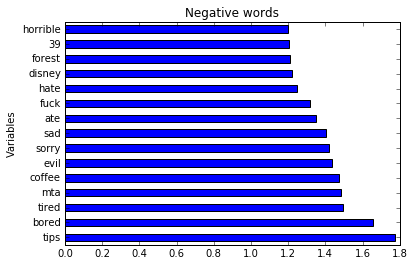

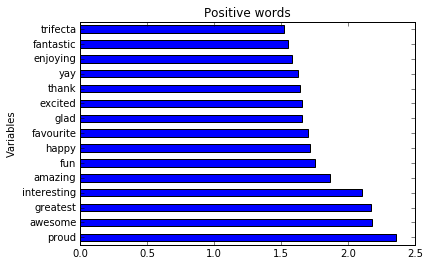

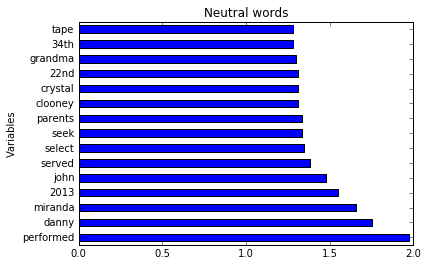

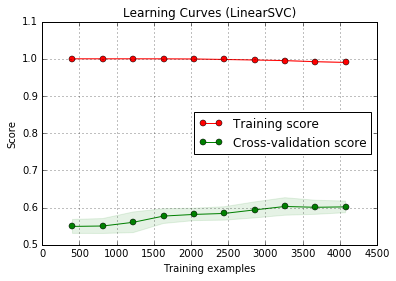

Accuracy on the training data :  0.98786407767
Accuracy on the testing data :  0.595498179411 

Training data Crosstab: 
 col_0       -1     0     1
Sentiment                 
-1         629    10     4
 0           2  2185    13
 1           1    25  1663
Testing data Crosstab: 
 col_0       -1    0    1
Sentiment               
-1         119  190  111
 0         155  999  322
 1          80  364  681 



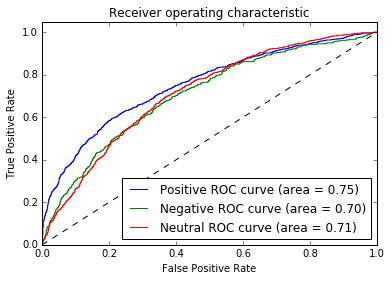

In [71]:
import warnings
warnings.filterwarnings('ignore')
classifier,target_training,target_testing,predictions_training,predictions_testing,training_set,testing_set= Classify(data, 0.6)

In [ ]:
from sklearn.metrics import f1_score
f1_score()

In [ ]:
dfBow = getBOWFeatures(semdf_train,1,1)

In [18]:
df = pd.read_csv('/Users/gautamborgohain/Downloads/sanders-twitter-0.2/corpus.csv')

In [19]:
df.columns = ['target','Sentiment','ID']
df.head()

,target,Sentiment,ID
0,apple,positive,126404574230740992
1,apple,positive,126402758403305474
2,apple,positive,126397179614068736
3,apple,positive,126395626979196928
4,apple,positive,126394830791254016


In [20]:
df['UID'] = 1

In [22]:
df = df[['ID','UID','Sentiment','target']]
df.head()

,ID,UID,Sentiment,target
0,126404574230740992,1,positive,apple
1,126402758403305474,1,positive,apple
2,126397179614068736,1,positive,apple
3,126395626979196928,1,positive,apple
4,126394830791254016,1,positive,apple


In [25]:
df.to_csv('/Users/gautamborgohain/Downloads/sanders-twitter-0.2/corpus2.csv', index=False)

In [32]:
tweet = 'RT @TODAYonline: Some SMRT staff upset over apparent disregard for workers’ safety https://t.co/7ZDQAwWQHr https://t.co/Nlg2ohMu1E'
re.sub('ST \||CNA \||TODAY \||COCONUTS \||ASIAONE \||TNP \||REDWIRE TIMES \||', '', tweet)

'@TODAYonline: Some SMstaff upset over apparent disregard for workers’ safety https://t.co/7ZDQAwWQHr https://t.co/Nlg2ohMu1E'

In [41]:
data_unlab_copy = pd.read_excel('/Users/gautamborgohain/Desktop/amozon_cell_sentiment.xlsx')
data_unlab_copy.columns = ['Tweet','Sentiment']
data_unlab_copy.head()



,Tweet,Sentiment
0,So there is no way for me to plug it in here i...,-1
1,"Good case, Excellent value.",1
2,I thought Motorola made reliable products!.,0
3,Battery for Motorola Razr.,0
4,Great for the jawbone.,1


In [39]:
len(df2)

15003

In [ ]:
df = pd.read()